# Optimization

In this notebook, we demonstrate the discussion in section TODO.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

## Data and Model for Demostration

Load and process MNIST dataset.

In [2]:
# Preprocess MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), _ = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train.reshape([-1, 28, 28, 1])  # add channel.
x_train = x_train / 255.0
y_train = y_train.astype('int32')

# Convert to dataset
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_train = ds_train.batch(64)

In [3]:
def build_model(model_type):
    if model_type == 0:
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, 'relu'),
            tf.keras.layers.Dense(64, 'relu'),
            tf.keras.layers.Dense(32, 'relu'),
            tf.keras.layers.Dense(10),
        ])
    elif model_type == 1:
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, 3),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(64, 3),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, 'relu'),
            tf.keras.layers.Dense(10),
        ])
    else:
        raise ValueError()

    # Build the model
    x_batch = tf.random.uniform([128, 28, 28, 1])
    _ = model(x_batch)

    return model


def get_num_params(model):
    num_params = 0
    for v in init_model.variables:
        num_params += tf.reduce_prod(tf.shape(v)).numpy()
    return num_params


init_model = build_model(1)
print(f'Number of parameters = {get_num_params(init_model)}')

Number of parameters = 1199882


Then define loss and training functions.

In [4]:
def cross_entropy_loss(logits, labels):
    """Compute cross entropy loss with a sparse operation."""
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels)
    return tf.reduce_mean(sparse_ce)


def train_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        loss_batch = cross_entropy_loss(y_pred, y_batch)
    grads = tape.gradient(loss_batch, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_batch

Function for demostration.

In [5]:
def clone_model(model):
    new_model = tf.keras.models.clone_model(model)
    for i, var in enumerate(model.variables):
        new_model.variables[i].assign(var)
    return new_model


def demostrate_optimizer(optimizer, epochs=5):
    model = clone_model(init_model)
    loss_values = []

    # Training process.
    for epoch in range(epochs):
        ds_iter = ds_train.as_numpy_iterator()
        while True:
            try:
                x_batch, y_batch = next(ds_iter)
            except StopIteration:
                break
            loss_batch = train_step(model, optimizer, x_batch, y_batch)
            loss_values.append(loss_batch.numpy())
            if np.isnan(loss_values[-1]):
                raise ValueError('NaN')
        print(f'epoch = {epoch}, loss = {np.mean(loss_values[-200:])}')

    print(f'Final loss = {np.mean(loss_values[-200:])}')
    plt.plot(loss_values)
    plt.title('Training loss.')
    plt.show()
    return loss_values, model, optimizer

We use Adam optimizer as baseline.

epoch = 0, loss = 0.06201259046792984
epoch = 1, loss = 0.034535862505435944
epoch = 2, loss = 0.020045503973960876
epoch = 3, loss = 0.014795181341469288
epoch = 4, loss = 0.010538799688220024
Final loss = 0.010538799688220024


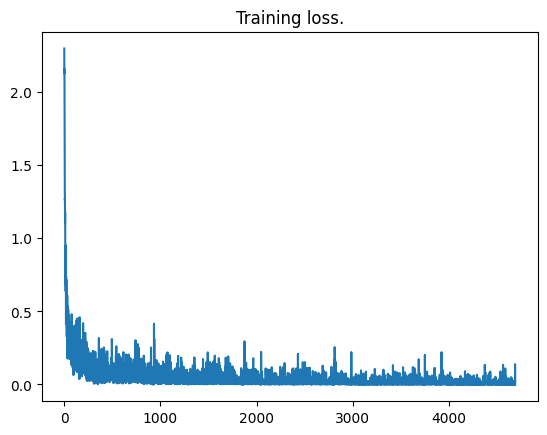

In [6]:
_, optimized_model, _ = demostrate_optimizer(tf.keras.optimizers.Adam())

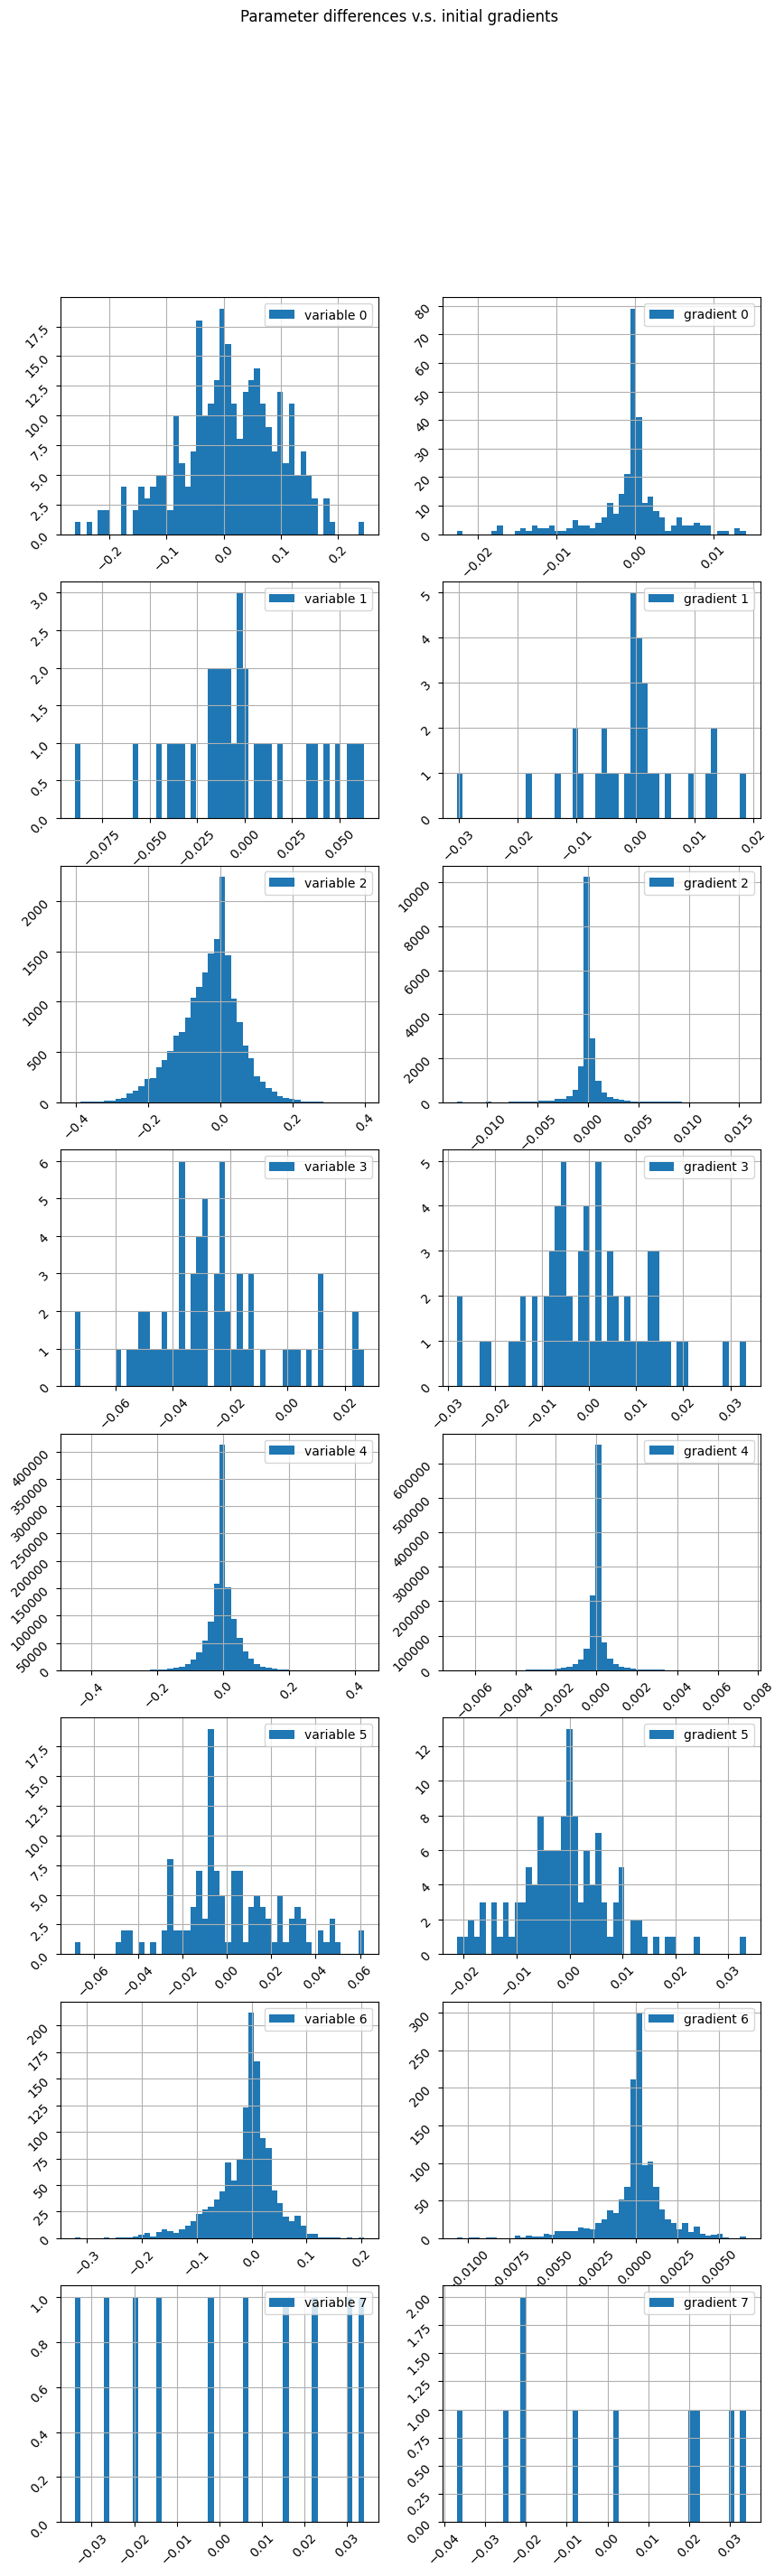

In [24]:
# Compute initial gradients
x_batch, y_batch = next(ds_train.as_numpy_iterator())
with tf.GradientTape() as tape:
    with tf.GradientTape() as tape:
        y_pred = init_model(x_batch)
        loss_batch = cross_entropy_loss(y_pred, y_batch)
    init_gradients = tape.gradient(loss_batch, init_model.variables)

# Plot histograms
num_variables = len(init_model.variables)
fig, axs = plt.subplots(num_variables, 2, figsize=(10, 4*num_variables))
for i in range(num_variables):
    axs[i][0].hist((optimized_model.variables[i] - init_model.variables[i]).numpy().reshape([-1]),
                   bins=50, label=f'variable {i}')
    axs[i][0].legend(loc='upper right')
    axs[i][0].grid()
    axs[i][0].tick_params(labelrotation=45)

    axs[i][1].hist(init_gradients[i].numpy().reshape([-1]),
                   bins=50, label=f'gradient {i}')
    axs[i][1].legend(loc='upper right')
    axs[i][1].grid()
    axs[i][1].tick_params(labelrotation=45)

fig.suptitle('Parameter differences v.s. initial gradients')
plt.show()

In [9]:
def get_variable_shapes(model):
    return [var.shape for var in model.variables]

In [10]:
class RGprop:

    def __init__(self, learning_rate=2e-4, decay_factor=0.95, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.epsilon = epsilon

    def build(self, variable_shapes):
        self.moving_averages = []
        for shape in variable_shapes:
            avg_grad = tf.Variable(tf.zeros(shape))
            self.moving_averages.append(avg_grad)
        return self

    def apply_gradients(self, grads_and_vars):
        for i, (grad, var) in enumerate(grads_and_vars):
            avg_grad = self.moving_averages[i]
            avg_grad.assign(
                self.decay_factor * avg_grad + (1-self.decay_factor) * grad)
            scale = tf.sqrt(tf.reduce_mean(tf.square(avg_grad)))
            var.assign_sub(
                self.learning_rate * avg_grad / (scale + self.epsilon))

Then, implemented the optimizer shown as a simple instance in section TODO.

epoch = 0, loss = 0.07591655850410461
epoch = 1, loss = 0.04122116044163704
epoch = 2, loss = 0.027379775419831276
epoch = 3, loss = 0.019199352711439133
epoch = 4, loss = 0.01785648614168167
Final loss = 0.01785648614168167


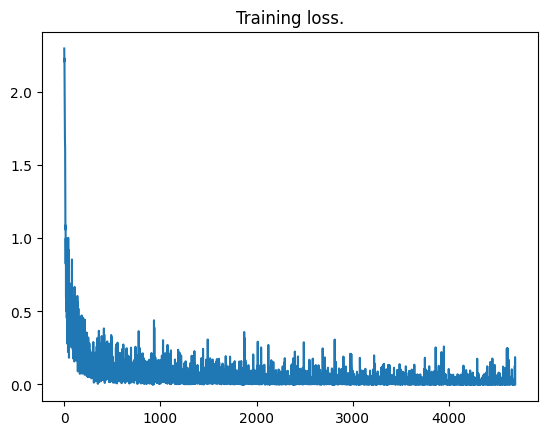

In [11]:
_ = demostrate_optimizer(RGprop().build(get_variable_shapes(init_model)))

In [12]:
class Signprop:

    def __init__(self, learning_rate=2e-4, decay_factor=0.95):
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor

    def build(self, variable_shapes):
        self.moving_averages = []
        for shape in variable_shapes:
            avg_grad = tf.Variable(tf.zeros(shape))
            self.moving_averages.append(avg_grad)
        return self

    def apply_gradients(self, grads_and_vars):
        for i, (grad, var) in enumerate(grads_and_vars):
            avg_grad = self.moving_averages[i]
            avg_grad.assign(
                self.decay_factor * avg_grad + (1-self.decay_factor) * grad)
            var.assign_sub(
                self.learning_rate * tf.math.sign(avg_grad))

epoch = 0, loss = 0.059443116188049316
epoch = 1, loss = 0.035296015441417694
epoch = 2, loss = 0.023342836648225784
epoch = 3, loss = 0.013621270656585693
epoch = 4, loss = 0.00982087291777134
Final loss = 0.00982087291777134


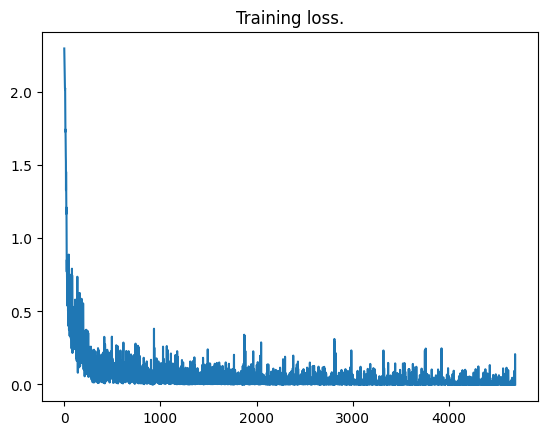

In [13]:
_ = demostrate_optimizer(Signprop().build(get_variable_shapes(init_model)))

## Conclusion

We find that the optimizer shown as a simple instance in the section just a little slower than the Adam optimizer. But the RAM occupition is half comparing with the later.